In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set_theme(style="ticks", context="talk")

In [124]:
data = pd.read_csv("characteristics_data_feb2017.csv")

In [125]:
data.drop(
    columns=[
        "q10",
        "q20",
        "q50",
        "prc",
        "a2me",
        "ato",
        "beme",
        "c",
        "cto",
        "d2a",
        "dpi2a",
        "e2p",
        "fc2y",
        "free_cf",
        "investment",
        "lturnover",
        "noa",
        "oa",
        "ol",
        "pcm",
        "pm",
        "prof",
        "q",
        "rna",
        "roa",
        "roe",
        "s2p",
        "sga2m",
        "at",
        "cum_return_12_2",
        "cum_return_12_7",
        "cum_return_1_0",
        "cum_return_36_13",
        "idio_vol",
        "spread_mean",
        "suv",
        "rel_to_high_price",
        "lev",
    ],
    inplace=True,
)

data.sort_values(by=["date"], ascending=[True], inplace=True)
data["date"] = pd.to_datetime(data["date"])
data.head()

,Unnamed: 0,yy,mm,date,permno,ret,lme,beta
214585,214586,1962,7,1962-07-31,19940,-0.010899,395763.625,0.599815
286044,286045,1962,7,1962-07-31,25160,-0.039216,39780.000,0.835357
290255,290256,1962,7,1962-07-31,25478,-0.056452,61984.500,-0.012614
214586,214587,1962,8,1962-08-31,19940,0.104683,389952.750,0.581311
286045,286046,1962,8,1962-08-31,25160,0.027211,38220.000,0.794090


In [126]:
def valid_entries(period, data):
    """Vraća id dionica koje postoje kroz cijeli testni i validacijski period"""

    if max(period) > data["date"].max():
        raise Exception(f"No data beyond 2014-05-31 available")

    elif min(period) < data["date"].min():
        raise Exception(f"No data before 1962-07-31 available")

    filtered_data = data.loc[data["date"].isin(period)]
    n_months = len(period)

    valid_ids = (
        filtered_data.groupby("permno")
        .filter(lambda x: x["date"].nunique() == n_months)["permno"]
        .unique()
        .tolist()
    )

    return valid_ids

In [127]:
def get_top_N_stocks(start_year, end_year, data=data, N=500, approach="capm"):
    """
    Vraća top N dionica po market capu u danom vremenskom periodu,
    samo za valid dionice koje postoje kroz cijeli period. Logika se mijenja ovisno o pristupu.
    """

    # definicija vremenskog perioda
    period = pd.date_range(
        start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq="M"
    )

    # provjera validnosti
    valid_ids = valid_entries(period, data)

    # podjela podataka na test i provjeru
    test_data = data.loc[
        data["date"].dt.year.between(start_year, end_year - 1)
        & data["permno"].isin(valid_ids)
    ]
    validation_data = data.loc[
        data["date"].dt.year.eq(end_year) & data["permno"].isin(valid_ids)
    ]

    if approach == "capm":
        # CAPM pristup: odabir top N dionica svaki mjesec (izmjenjuju se)
        top_N_test = (
            test_data.sort_values(["date", "lme"], ascending=[True, False])
            .groupby("date")
            .head(N)
            .reset_index(drop=True)
        )
    elif approach == "equilibrium":
        # Equilibrium pristup: odabir top N dionica samo u prvom trenutku
        first_date = test_data["date"].min()
        top_N_permnos = (
            test_data.loc[test_data["date"] == first_date]
            .nlargest(N, "lme")["permno"]
            .unique()
        )

        top_N_test = test_data.loc[test_data["permno"].isin(top_N_permnos)].copy()
    else:
        raise ValueError("izaberi capm ili equilibrium")

    # odabir permnoa koji idu u validation df
    if approach == "capm":
        top_N_test_permnos = top_N_test["permno"].unique()
    elif approach == "equilibrium":
        top_N_test_permnos = top_N_permnos

    # filtriranje
    top_N_validation = (
        validation_data.loc[validation_data["permno"].isin(top_N_test_permnos)]
        .sort_values(["date", "lme"], ascending=[True, False])
        .set_index("date")
    )

    return top_N_test, top_N_validation

In [128]:
def construct_index(t):

    constructed_index = pd.DataFrame(columns=["date", "index_ret"])
    t["weight"] = t.groupby("date")["lme"].transform(lambda x: x / x.sum())
    t["weighted_ret"] = t["ret"] * t["weight"]
    t["weighted_beta"] = t["beta"] * t["weight"]

    constructed_index = (
        t.groupby("date", as_index=False)
        .agg({"weighted_ret": "sum", "weighted_beta": "sum"})
        .rename(columns={"weighted_ret": "index_ret", "weighted_beta": "index_beta"})
    )
    constructed_index.set_index("date", inplace=True)

    # samo weightovi u pocetnom trenutku (za EQ pristup)
    weights = t.loc[t["date"] == t["date"].min()][["permno", "weight"]]
    weights.set_index("permno", inplace=True)

    return constructed_index, weights

In [129]:
kenneth_french_df = pd.read_csv("F-F_Research_Data_Factors.CSV")  # monthly factors

kenneth_french_df["Date"] = pd.to_datetime(kenneth_french_df["Date"], format="%Y%m")
kenneth_french_df = kenneth_french_df.set_index("Date")
kenneth_french_df /= 100

kenneth_french_df

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.0296,-0.0256,-0.0243,0.0022
1926-08-01,0.0264,-0.0117,0.0382,0.0025
1926-09-01,0.0036,-0.0140,0.0013,0.0023
1926-10-01,-0.0324,-0.0009,0.0070,0.0032
1926-11-01,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2024-07-01,0.0124,0.0680,0.0574,0.0045
2024-08-01,0.0161,-0.0355,-0.0113,0.0048
2024-09-01,0.0174,-0.0017,-0.0259,0.0040


In [130]:
"""
Parametri:
    data: DataFrame s povratima dionica
    kenneth_french_df: DataFrame s bezrizičnim mjesečnim stopama
    start_year: Prva godina analize
    end_year: Validacijska godina analize
    window_t: Veličina prozora
    N: Broj dionica za razmatranje po market capu
"""
start_year = 1978
end_year = 2014
window_t = 5
N = 10
model = LinearRegression()

In [131]:
def visualize(df, r2):
    plt.figure(figsize=(8, 6))

    sns.scatterplot(
        data=df, x="predicted", y="real", color="blue", alpha=0.1, edgecolor=None
    )

    min_val = min(df["predicted"].min(), df["real"].min())
    max_val = max(df["predicted"].max(), df["real"].max())

    plt.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--")

    plt.text(
        0.05,
        0.95,
        f"R² = {r2:.2f}",
        transform=plt.gca().transAxes,
        ha="left",
        va="top",
        fontsize=12,
    )

    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.title("Predicted vs. Actual Excess Returns")
    sns.despine()
    plt.tight_layout()
    plt.show()

# CAPM pristup

In [132]:
comparison_rows = []

for i in range(start_year + window_t, end_year):
    # vrati test i validation data u df
    t, v = get_top_N_stocks(i - window_t, i, data, N, approach="capm")
    # konstruiramo indeks od market cap weightova
    constructed_index, _ = construct_index(t)

    start_date_test = f"{i- window_t}-01-01"
    end_date_test = f"{i - 1}-12-31"

    start_date_validation = f"{i}-01-01"
    end_date_validation = f"{i}-12-31"

    # bezrizične stope (mjesečne) za dani period
    rf_rates = kenneth_french_df.loc[start_date_test:end_date_test]["RF"]
    rf_rates_validation = kenneth_french_df.loc[
        start_date_validation:end_date_validation
    ]["RF"]

    # index minus bezrizična stopa
    constructed_index["index_ret"].add(-rf_rates)
    v["ret"].add(-rf_rates_validation)

    # pretvaranje validacijskog df-a u anualiziranu formu za usporedbu
    validation_annual = (
        v.groupby(["permno", v.index.year])["ret"]
        .agg(lambda x: (1 + x).prod() - 1)
        .reset_index(name="annual_return")
    )
    validation_annual_dict = dict(
        zip(validation_annual["permno"], validation_annual["annual_return"])
    )

    # očekivani povrat indeksa kao APR od ukupnog povrata u periodu
    total_return = (1 + constructed_index["index_ret"]).prod() - 1
    e = (1 + total_return) ** (1 / window_t) - 1

    for permno in t["permno"].unique():
        permno_data = data.loc[
            (data["date"] >= start_date_test)
            & (data["date"] <= end_date_test)
            & (data["permno"] == permno)
        ].copy()

        # mora se i od povrata dionice oduzeti bezrizična stopa
        X = constructed_index["index_ret"].values.reshape(-1, 1)
        y = permno_data["ret"].values - rf_rates.values

        model.fit(X, y)
        bi = model.coef_[0]
        alpha = model.intercept_

        mu = alpha + (e * bi)
        real = validation_annual_dict.get(permno, None)

        # naive predikcija da je predicted return APR povrata u periodu
        total_return_stock = (1 + y).prod() - 1
        baseline = (1 + total_return_stock) ** (1 / window_t) - 1

        comparison_rows.append(
            {
                "test_period": f"{i-window_t} - {i-1}",
                "permno": permno,
                "predicted": mu,
                "real": real,
                "beta": bi,
                "baseline": baseline,
            }
        )


comparison = pd.DataFrame(comparison_rows)

In [133]:
y_true = comparison["real"].values
y_pred = comparison["predicted"].values
y_baseline = comparison["baseline"].values

r2 = 1 - np.mean((y_pred - y_true) ** 2) / np.mean((y_baseline - y_true) ** 2)

print("Overall Out-of-Sample R²:", r2)

Overall Out-of-Sample R²: 0.1598152753975708


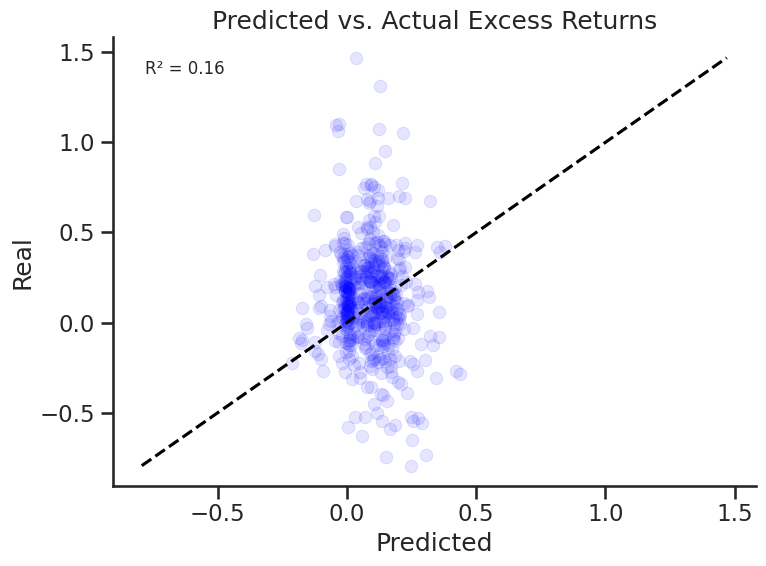

In [134]:
visualize(comparison, r2)

# Ekvilibrijski pristup

In [135]:
equilibrium_rows = []

for i in range(start_year + window_t, end_year):

    start_date = f"{i-window_t}-01-01"
    end_date = f"{i-1}-12-31"

    t, v = get_top_N_stocks(i - window_t, i, data, N, approach="equilibrium")
    constructed_index, weights = construct_index(t)
    rf_rates = kenneth_french_df.loc[start_date:end_date]["RF"]

    validation_annual = (
        v.groupby(["permno", v.index.year])["ret"]
        .agg(lambda x: (1 + x).prod() - 1)
        .reset_index(name="annual_return")
    )
    validation_annual_dict = dict(
        zip(validation_annual["permno"], validation_annual["annual_return"])
    )

    # 1) Kovarijancijska matrica
    cov_matrix = t.pivot(index="date", columns="permno", values="ret").cov() * 12

    # 2) lambda (estimirana)
    market_variance = constructed_index["index_ret"].var()
    constructed_index["index_ret"].add(-rf_rates)
    realized_premium = (constructed_index["index_ret"]).mean()

    lam = realized_premium / market_variance

    # 3) namještanje weightova
    weights_series = weights.sort_index(ascending=True)["weight"]

    # 4) izračun
    mu = lam * (cov_matrix @ weights_series)

    for permno in t["permno"].unique():
        real = validation_annual_dict.get(permno, None)
        predicted = mu.get(permno, None)
        baseline = (
            1
            + data.loc[
                (data["date"] >= start_date)
                & (data["date"] <= end_date)
                & (data["permno"] == permno)
            ]["ret"].prod()
        ) ** (1 / window_t) - 1
        equilibrium_rows.append(
            {
                "test_period": f"{i-window_t} - {i-1}",
                "permno": permno,
                "predicted": predicted,
                "real": real,
                "lambda": f"{lam:.2f}",
                "baseline": baseline,
            }
        )


comparison_equilibrium = pd.DataFrame(equilibrium_rows)

In [136]:
y_true = comparison_equilibrium["real"].values
y_pred = comparison_equilibrium["predicted"].values
y_baseline = comparison_equilibrium["baseline"].values

r2 = 1 - np.mean((y_pred - y_true) ** 2) / np.mean((y_baseline - y_true) ** 2)

print("Overall Out-of-Sample R²:", r2)

Overall Out-of-Sample R²: 0.09468496680384686


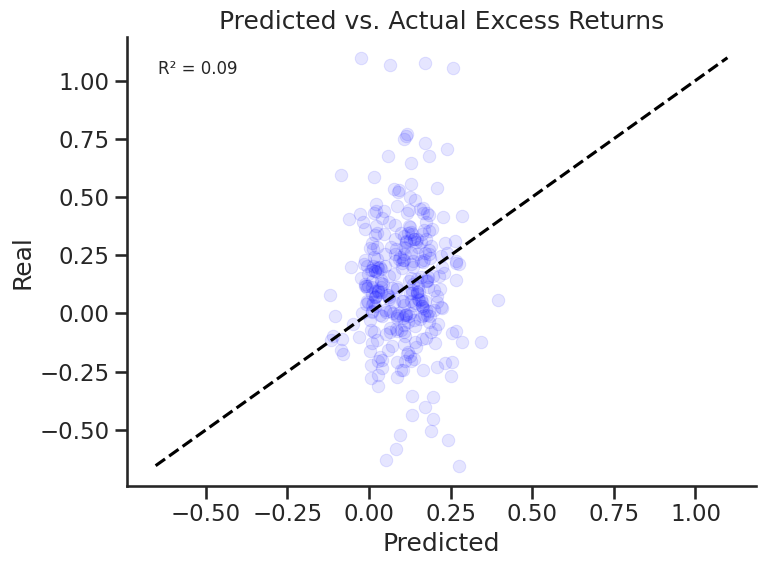

In [137]:
visualize(comparison_equilibrium, r2)